# Lin Regr

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from itertools import combinations

In [66]:
df = pd.read_csv('data_cleaned.csv')

## Filtering Out Not Interesting Data

We are starting by excluding a number of not interesting columns that highly correlate with our dependent variable.

In [71]:
df_for_corr = df.iloc[:,6:]

In [72]:
df_for_corr = df_for_corr.corr()

In [73]:
# checking positive values first

In [75]:
df_for_corr['poor_mental_health_days'].sort_values(ascending = False).head(10)

poor_mental_health_days             1.000000
frequent_mental_distress            0.953254
poor_physical_health_days           0.919823
frequent_physical_distress          0.878407
poor_health                         0.743129
smokers                             0.739957
insufficient_sleep                  0.691513
diabetes                            0.655154
premature_age_adjusted_mortality    0.647103
children_in_oiverty                 0.638065
Name: poor_mental_health_days, dtype: float64

In [77]:
columns_to_exclude = []
columns_to_exclude.extend(
    ['frequent_mental_distress', 'poor_physical_health_days', 'frequent_physical_distress', 
    'poor_health'] 
)

In [78]:
df_for_corr['poor_mental_health_days'].sort_values(ascending = True).head(10)

life_expectancy           -0.633379
excessive_drinking        -0.620358
median_household_income   -0.559596
college                   -0.546793
food_environment_index    -0.403171
mammography_screenings    -0.342726
social_associations       -0.330864
exercise_acces            -0.215343
asian                     -0.197639
uninsured_children        -0.183329
Name: poor_mental_health_days, dtype: float64

In [79]:
columns_to_exclude.extend(
    ['life_expectancy'] 
)

In [80]:
df.drop(labels = columns_to_exclude, axis = 1, inplace = True)
df.shape

(3142, 63)

## Checking for Multicollinearity

In [121]:
y = df['poor_mental_health_days']
X = df.drop(['FIPS_state', 'FIPS_county', 'FIPS_full', 'state', 'county', 'year',
    'poor_mental_health_days'], axis = 1)

In [105]:
# dropping the values with the 10 highest vif score and re-running it

In [122]:
vif_threshold = 10

columns_to_drop_vif = []
highest_vif_too_high = True

while highest_vif_too_high:
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_list = list(zip(X.columns, vif))
    vif_list = sorted(vif_list, key= lambda x: x[1], reverse = True)
    if vif_list[0][1] > vif_threshold:
        current_column_to_drop = vif_list[0][0]
        print(current_column_to_drop)
        columns_to_drop_vif.append(current_column_to_drop)
        X.drop(current_column_to_drop, axis = 1, inplace = True)
    else:
        highest_vif_too_high = False
    

uninsured
nonhispanic_whit
females
food_environment_index
premature_age_adjusted_mortality
insufficient_sleep
homeownership
driving_alone_work
high_school_graduation
obese
smokers
diabetes
below_age18
income_inequality
median_household_income
physically_inactive
college
food_insecurity
mammography_screenings
severe_housing_problems
LBW
YPLL
excessive_drinking
above_age65
children_in_oiverty
air_pollution
children_in_singleparent_household
uninsured_adults
children_elig_lunch
injury_deaths
flu_vaccinated
severe_housing_cost_burden
exercise_acces
teen_birth_rate
unemployment


In [126]:
correl_test_df = pd.DataFrame()
correl_test_df['column_name'] = columns_to_drop_vif

In [127]:
correl_list = []

for column in columns_to_drop_vif:
    current_correl = df['poor_mental_health_days'].corr(df[column])
    correl_list.append(current_correl)

In [128]:
correl_test_df['correlation_with_pmhd'] = correl_list

In [129]:
correl_test_df.sort_values('correlation_with_pmhd', ascending = False)

,column_name,correlation_with_pmhd
10,smokers,0.739957
5,insufficient_sleep,0.691513
11,diabetes,0.655154
4,premature_age_adjusted_mortality,0.647103
24,children_in_oiverty,0.638065
17,food_insecurity,0.608685
21,YPLL,0.591831
15,physically_inactive,0.517016
26,children_in_singleparent_household,0.497505
33,teen_birth_rate,0.495828


We decided to follow this process: 
- Create a list of variables we would exclude based on VIF
- Calculate the correlation with the dependenta variable, and keep the variables which correlate by more than 0.5 (in absolute value), and exclude the rest
- This way, we exclude a number of variables which do not highly correlate with the base value but produce multicollinearity in the model
- We decided to suffer the consequences of keeping the rest. 

In [130]:
columns_to_drop_vif_corr = correl_test_df[np.abs(correl_test_df['correlation_with_pmhd']) < 0.5]['column_name']

In [133]:
columns_to_drop_vif_corr = columns_to_drop_vif_corr.tolist()

In [135]:
df.drop(labels = columns_to_drop_vif_corr, axis = 1, inplace = True)
df.shape

(3142, 39)

In [136]:
# checking VIF for remaining columns
X = df.drop(['FIPS_state', 'FIPS_county', 'FIPS_full', 'state', 'county', 'year',
    'poor_mental_health_days'], axis = 1)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_list = list(zip(X.columns, vif))
vif_list = sorted(vif_list, key= lambda x: x[1], reverse = True)

In [137]:
vif_list

[('premature_age_adjusted_mortality', 233.25558219740464),
 ('insufficient_sleep', 217.44478465512395),
 ('YPLL', 142.864504054577),
 ('smokers', 113.91935364696032),
 ('diabetes', 86.14532969642397),
 ('physically_inactive', 82.62067354332544),
 ('median_household_income', 67.47821486341186),
 ('college', 60.47365117392558),
 ('excessive_drinking', 55.6495204756171),
 ('food_insecurity', 51.4107881277985),
 ('children_in_oiverty', 40.54168549401643),
 ('driving_alone_longcommute', 15.038739395675206),
 ('rural', 12.075962813949465),
 ('preventable_hospital_stays', 11.271039772317804),
 ('chlamydia_rate', 9.348359124896016),
 ('uninsured_children', 8.208571993266926),
 ('social_associations', 7.808511710237588),
 ('PCP', 6.702281007324137),
 ('hispanic', 6.597780451870504),
 ('dentists', 5.465275028559841),
 ('nonhisp_africanamerican', 5.191603125182524),
 ('alcohol_impaired_driving_deaths', 5.13016212246894),
 ('notproficient_english', 4.988970512505101),
 ('violent_crime', 4.46082959

In [138]:
# we decided to live with that

__Summary__:
<br>
We calculated the variables we would exclude based on VIF, step by step removing one from the data. Then, we calculated the correlation these variables have with the dependent variable. We excluded variables which fulfiled two criteria: 
- on the VIF list
- absolute correlation with dependent variable < 0.5 in absolute value

## Checking for Linearity

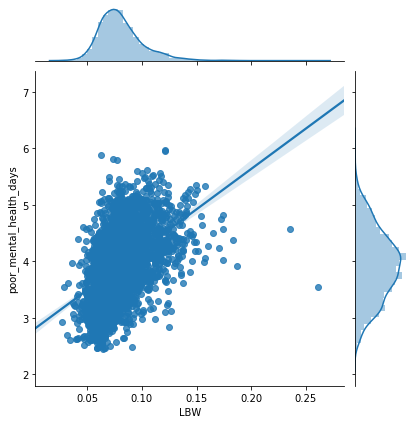

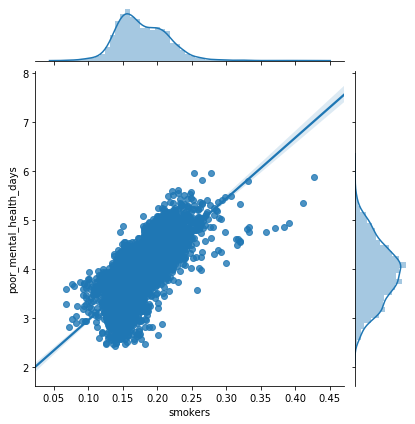

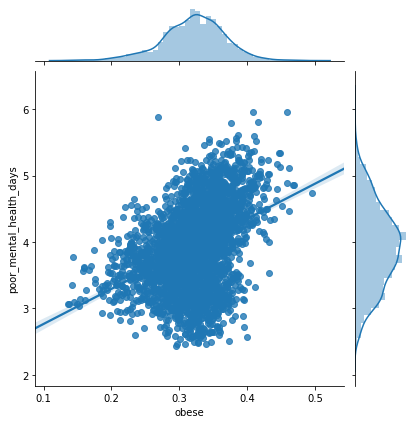

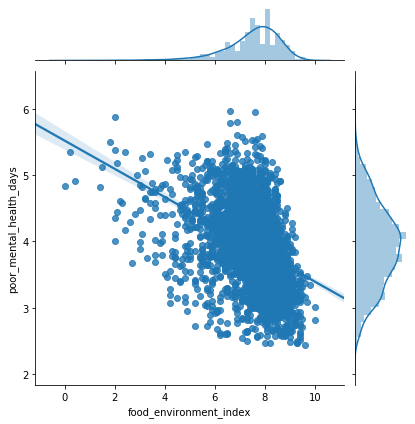

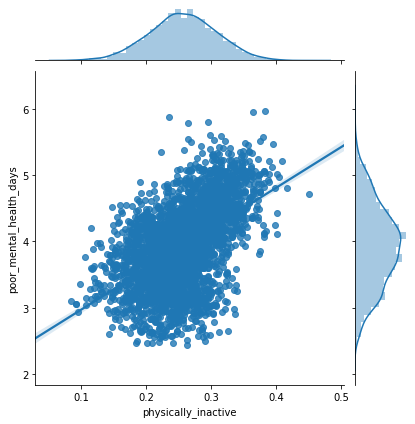

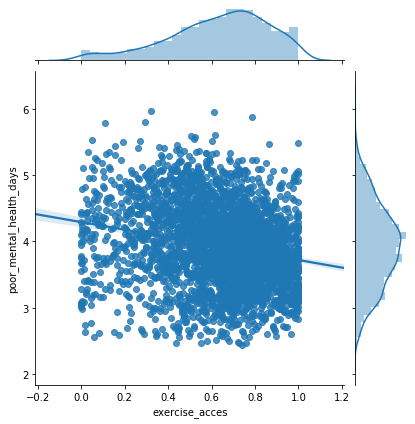

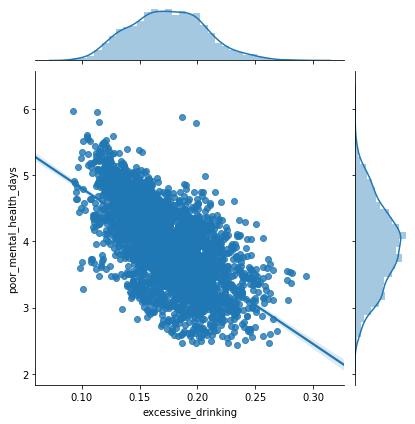

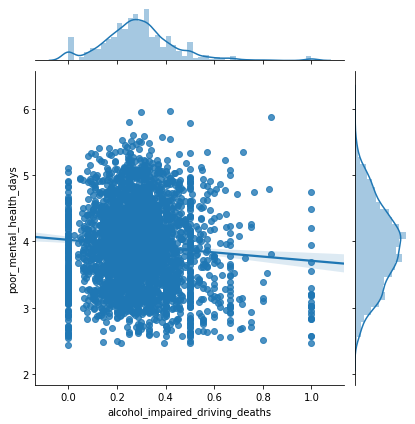

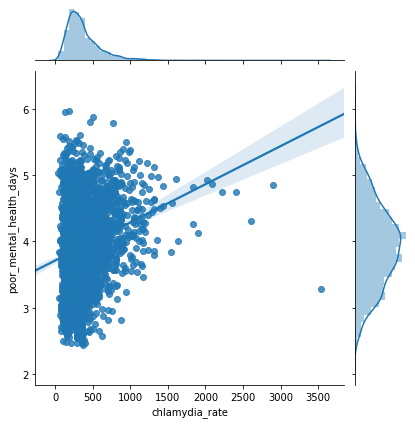

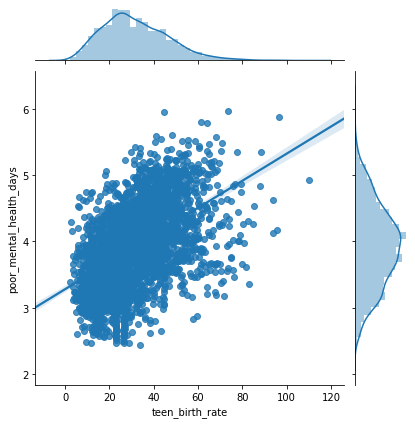

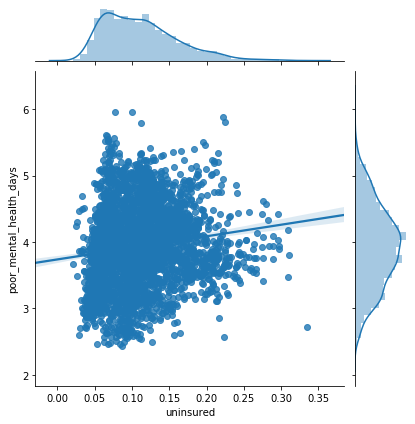

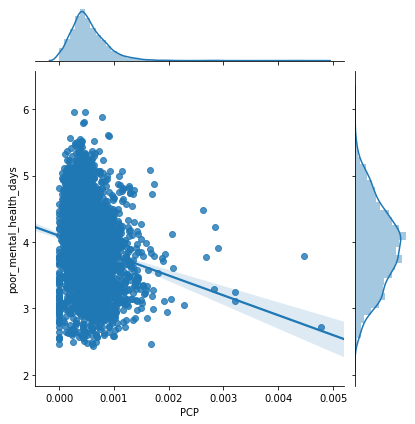

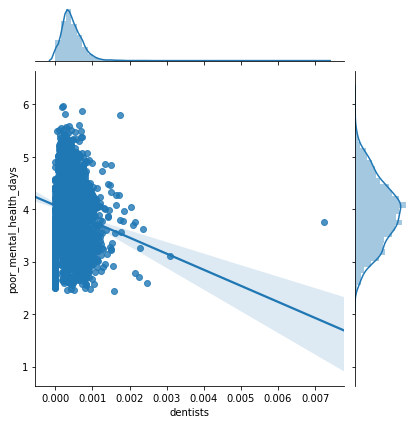

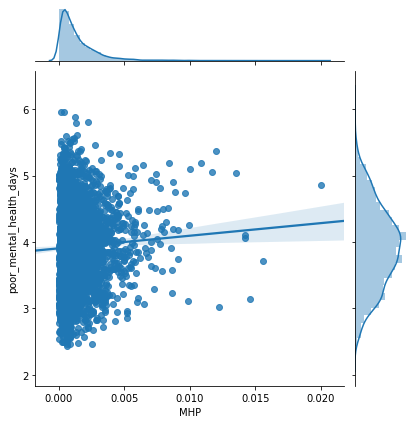

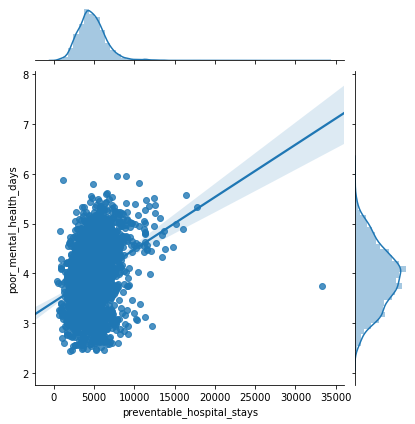

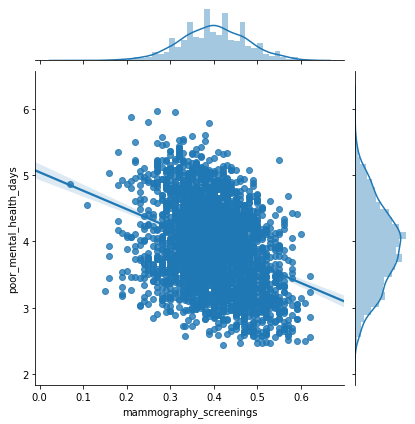

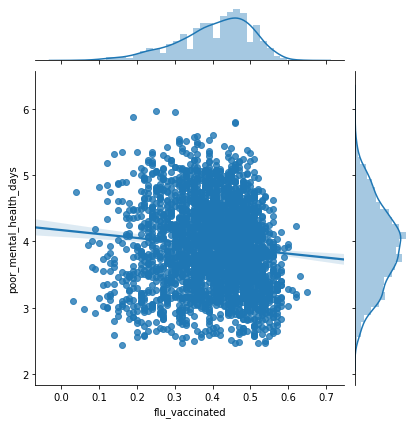

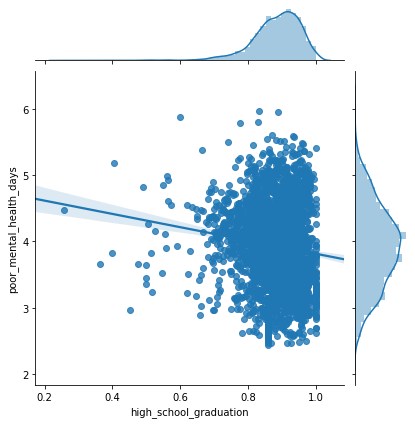

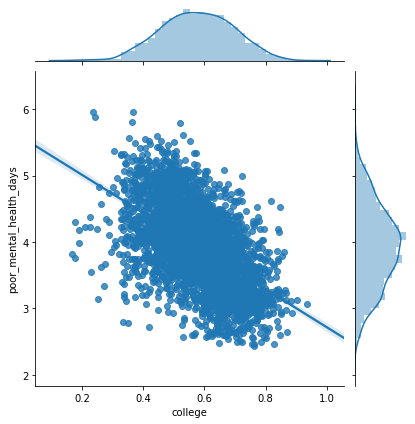

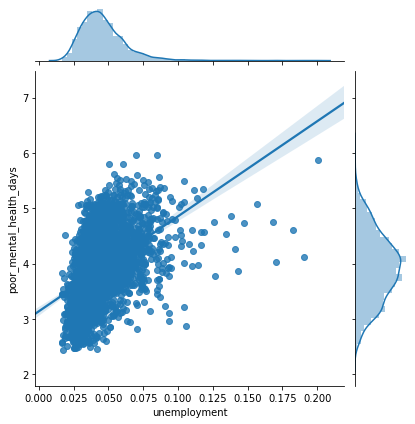

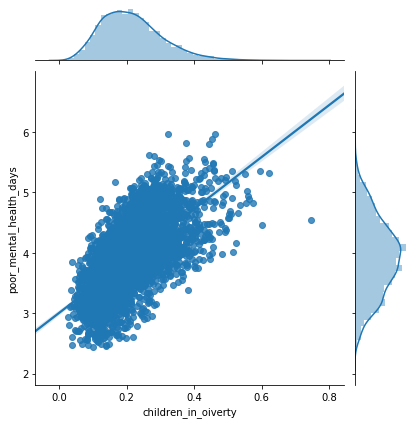

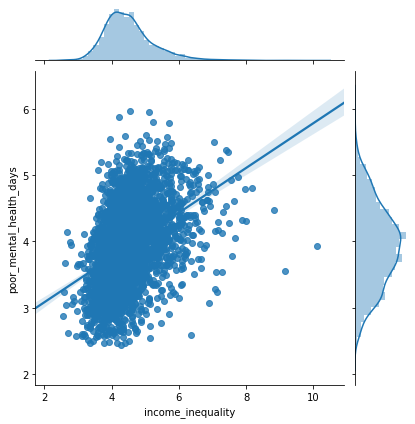

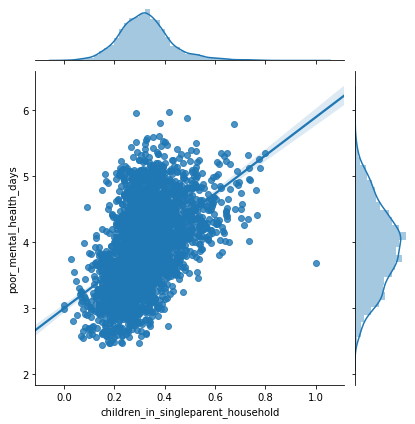

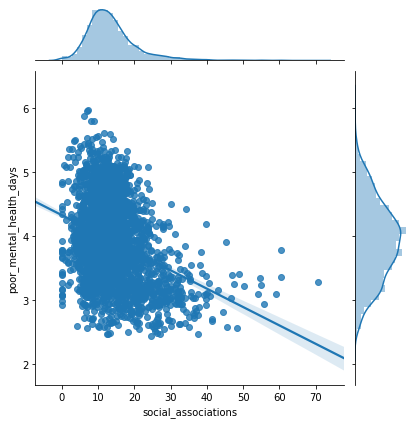

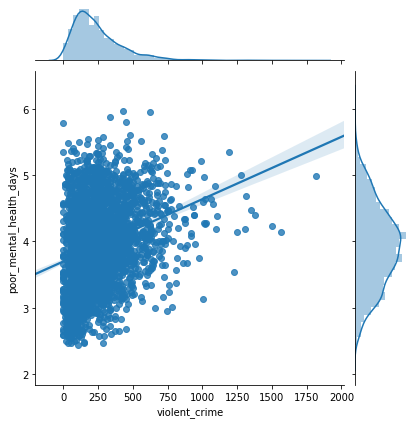

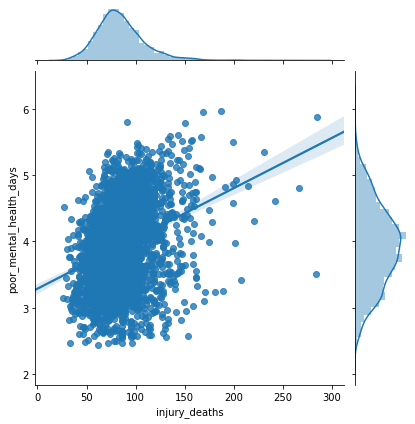

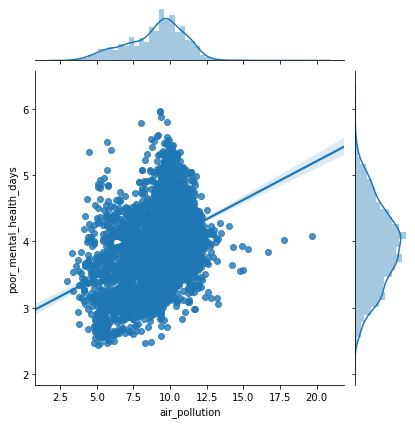

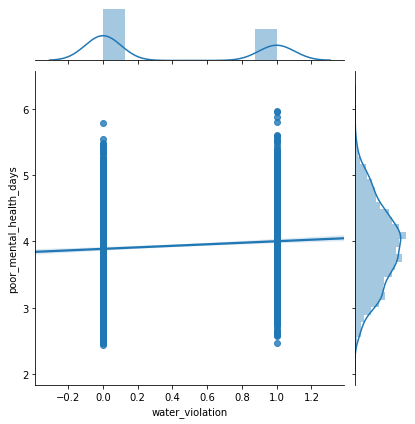

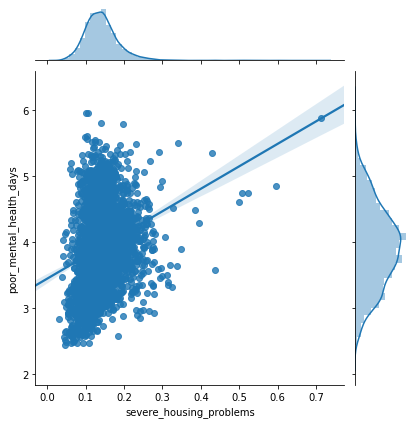

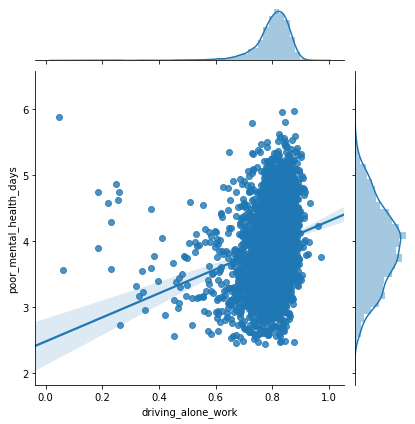

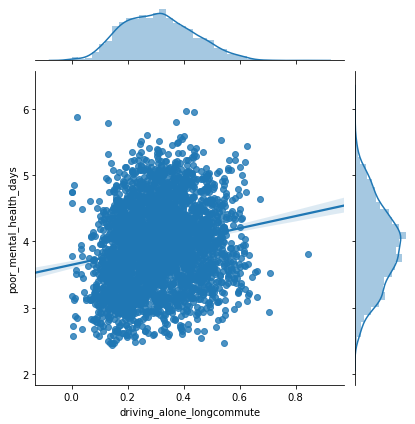

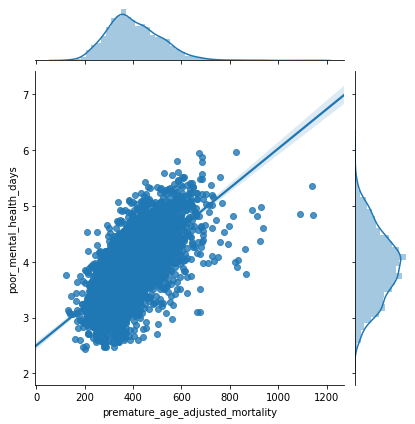

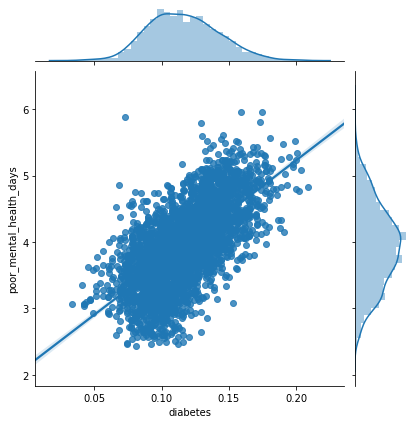

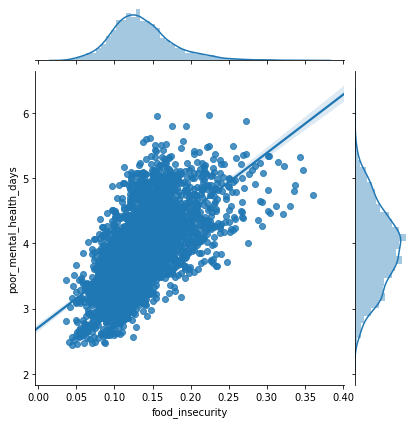

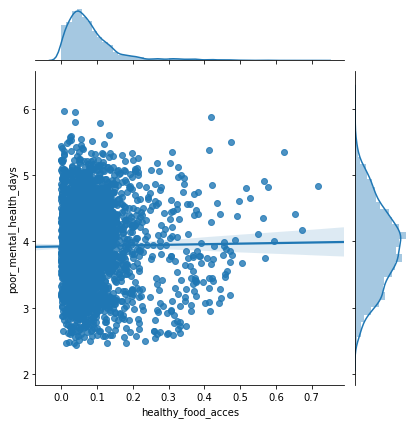

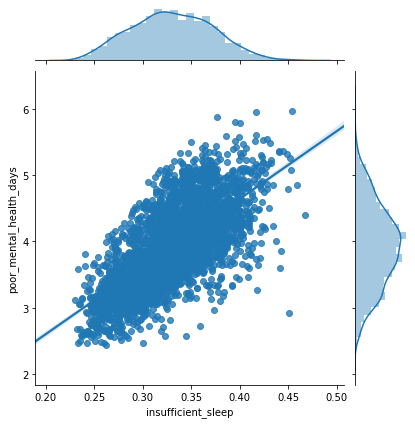

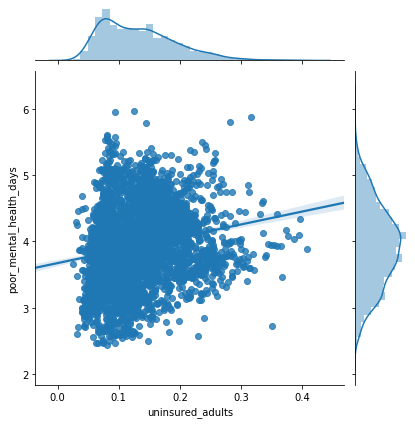

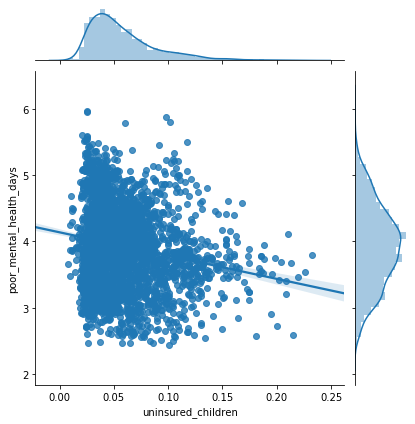

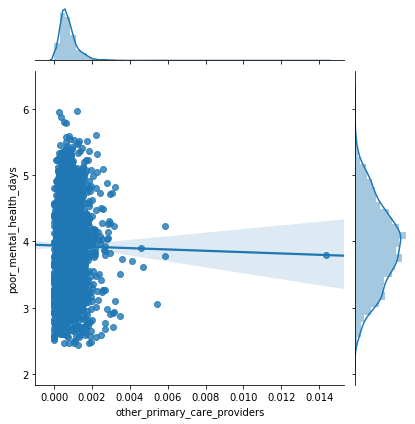

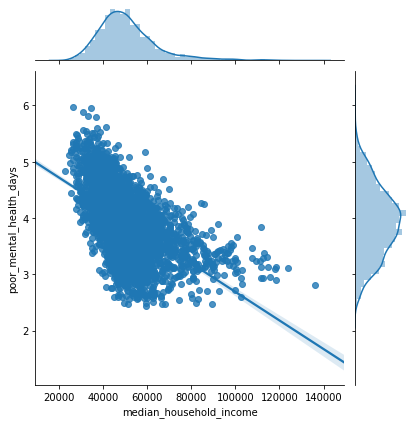

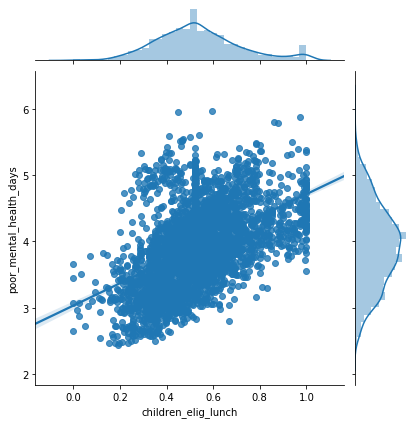

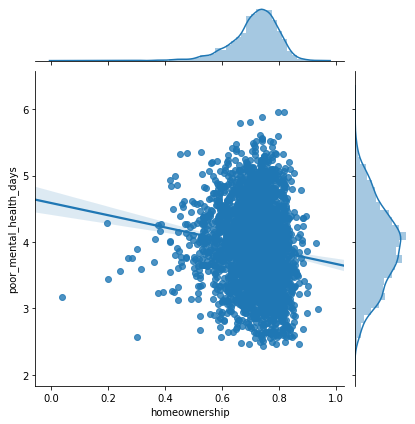

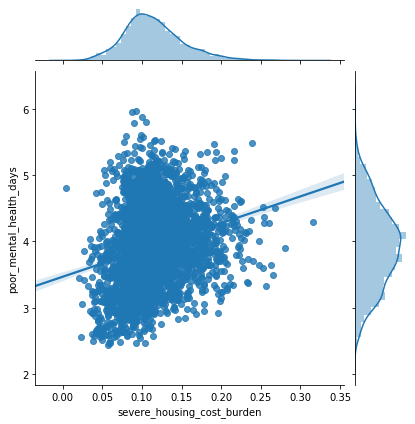

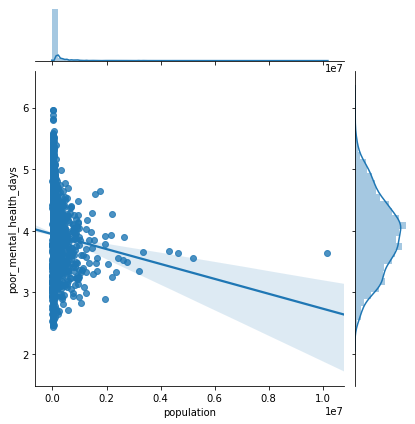

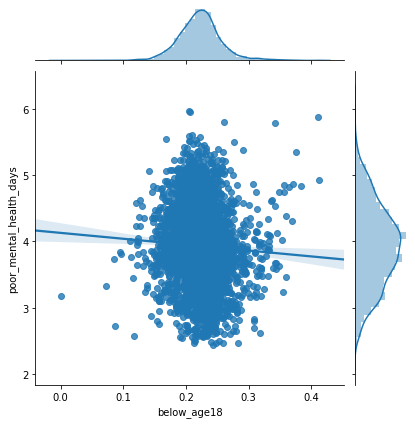

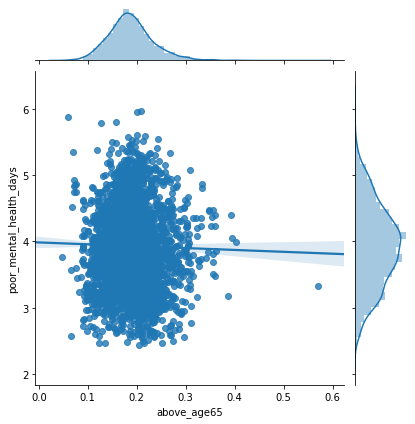

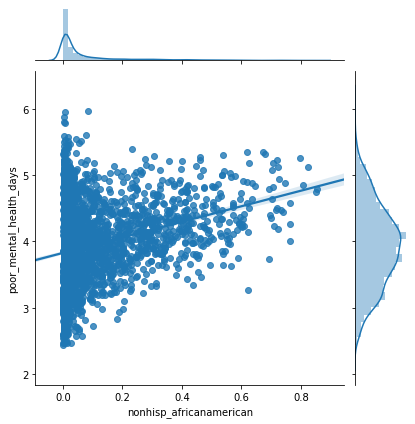

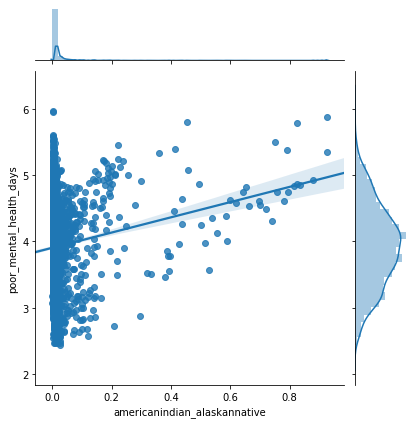

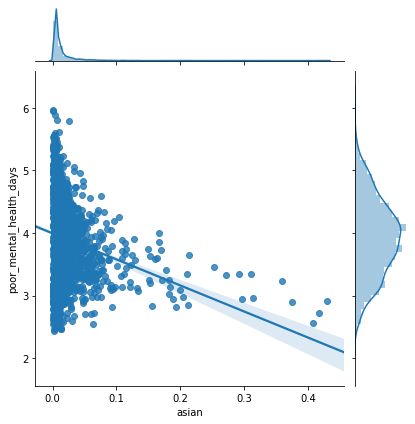

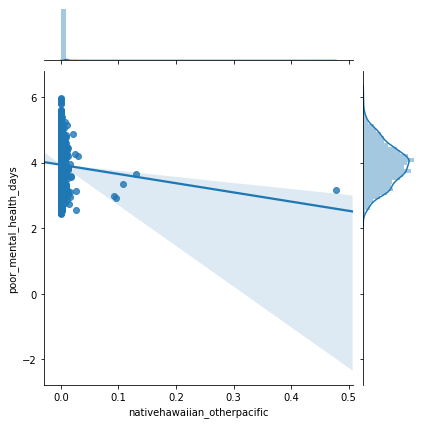

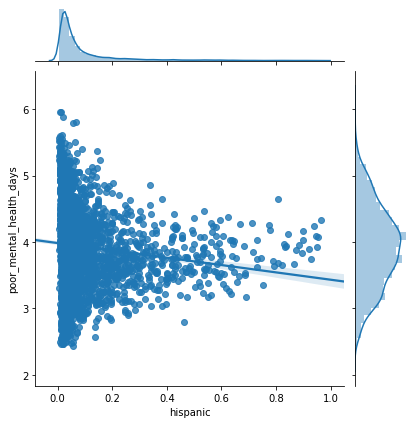

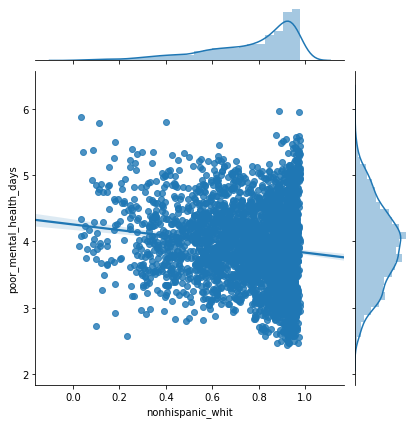

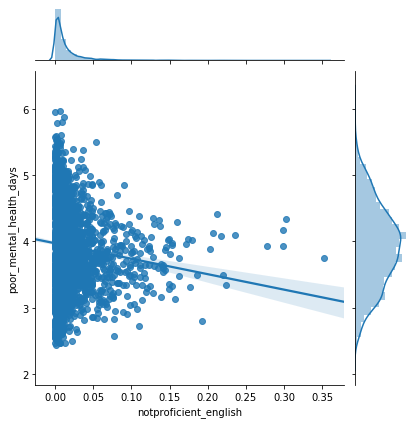

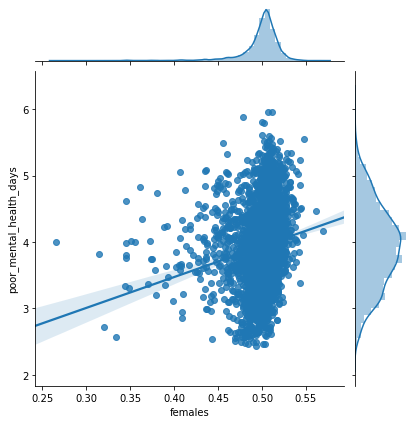

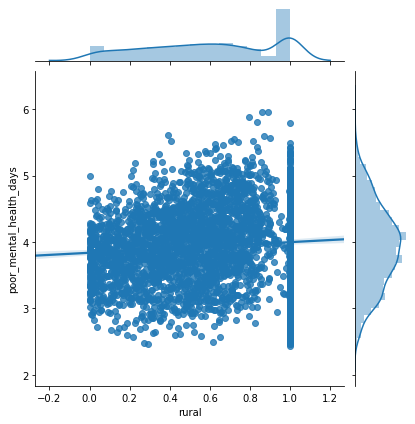

In [15]:
for column in X.columns: 
    sns.jointplot(column, 'poor_mental_health_days', data=df, kind='reg')
    plt.show()

We think is is linear enough in all variables. 
<br>

An alternative method would be to calculate the log and sqrt of all the valuables, and put them in, but in the interest of time we are not doing that. 

## Train - Test Split

In [139]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Baseline Model

In [140]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Using a K-fold model overall, our dataset is quite small. 

In [141]:
regression = LinearRegression()

crossvalidation = KFold(n_splits=5, shuffle=True, random_state= 42)
baseline = np.mean(cross_val_score(regression, X_train_scaled, y_train, scoring='r2', cv=crossvalidation))
baseline

0.8094197441499358

The baseline model's R^2 is 0.81, this is what we are going to compare against. 

## Interactions

In [144]:
combs = list(combinations(X_train.columns, 2))

In [145]:
# the cell runs for a while
interactions = []

for comb in combs:
    
    data = X_train.copy()
    
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y_train, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score, 3)))
            

In [74]:
# we are adding the interactions that increased the average R_squared to over 0.835 (rounded to 3 decimal places)

In [197]:
interactions = sorted(interactions, key = lambda x: x[2], reverse = True)

In [326]:
interactions_to_add = [interaction for interaction in interactions[:10]]

In [327]:
interactions_to_add

[('physically_inactive', 'excessive_drinking', 0.817),
 ('uninsured_children', 'nonhisp_africanamerican', 0.816),
 ('physically_inactive', 'premature_age_adjusted_mortality', 0.815),
 ('physically_inactive', 'diabetes', 0.815),
 ('physically_inactive', 'college', 0.814),
 ('children_in_oiverty', 'social_associations', 0.814),
 ('population', 'rural', 0.814),
 ('YPLL', 'physically_inactive', 0.813),
 ('physically_inactive', 'americanindian_alaskannative', 0.813),
 ('excessive_drinking', 'rural', 0.813)]

In [156]:
physical_inactivity = np.asarray(X_train[['physically_inactive']]).reshape(len(X_train[['physically_inactive']]))

high_physical_inactivity = X_train[physical_inactivity > np.percentile(physical_inactivity, 67)]

med_physical_inactivity = X_train[(physical_inactivity > np.percentile(physical_inactivity, 33)) & 
                                   (physical_inactivity <= np.percentile(physical_inactivity, 67))]

low_physical_inactivity = X_train[physical_inactivity <= np.percentile(physical_inactivity, 33)]

In [168]:
phys_inactivity_category = []
for inactive in X_train.physically_inactive:
    if inactive > np.percentile(physical_inactivity, 67):
        phys_inactivity_category.append('high_inactivity')
    elif inactive > np.percentile(physical_inactivity, 33) and inactive <= np.percentile(physical_inactivity, 67):
        phys_inactivity_category.append('med_inactivity')
    elif inactive <= np.percentile(physical_inactivity, 67):
        phys_inactivity_category.append('low_inactivity')                                
        
X_train['physical_inactivity_cat'] = phys_inactivity_category

In [187]:
data = pd.concat([X_train, y_train], axis =1)
X_train_high_pi = data[data['physical_inactivity_cat'] == 'high_inactivity']
X_train_medium_pi = data[data['physical_inactivity_cat'] == 'med_inactivity']
X_train_low_pi = data[data['physical_inactivity_cat'] == 'low_inactivity']

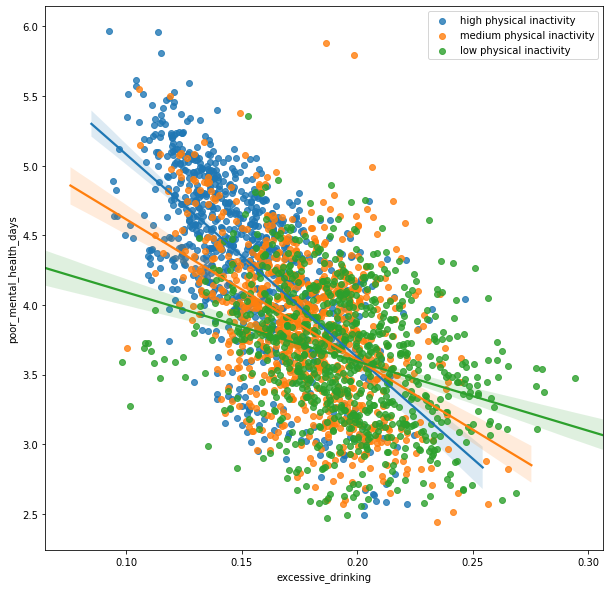

In [193]:
plt.figure(figsize = (10,10))
sns.regplot(x = X_train_high_pi['excessive_drinking'], y = X_train_high_pi['poor_mental_health_days'], label='high physical inactivity')
sns.regplot(x = X_train_medium_pi['excessive_drinking'], y = X_train_medium_pi['poor_mental_health_days'], label='medium physical inactivity')
sns.regplot(x = X_train_low_pi['excessive_drinking'], y = X_train_low_pi['poor_mental_health_days'], label='low physical inactivity')
plt.legend()
plt.show()



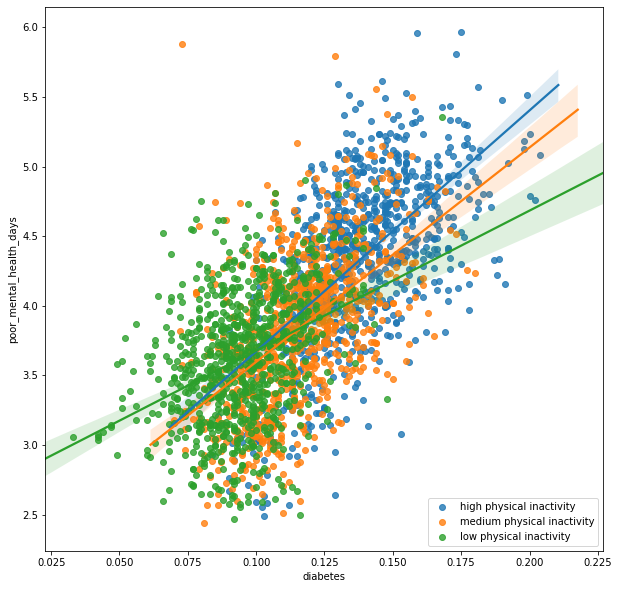

In [194]:
plt.figure(figsize = (10,10))
sns.regplot(x = X_train_high_pi['diabetes'], y = X_train_high_pi['poor_mental_health_days'], label='high physical inactivity')
sns.regplot(x = X_train_medium_pi['diabetes'], y = X_train_medium_pi['poor_mental_health_days'], label='medium physical inactivity')
sns.regplot(x = X_train_low_pi['diabetes'], y = X_train_low_pi['poor_mental_health_days'], label='low physical inactivity')
plt.legend()
plt.show()

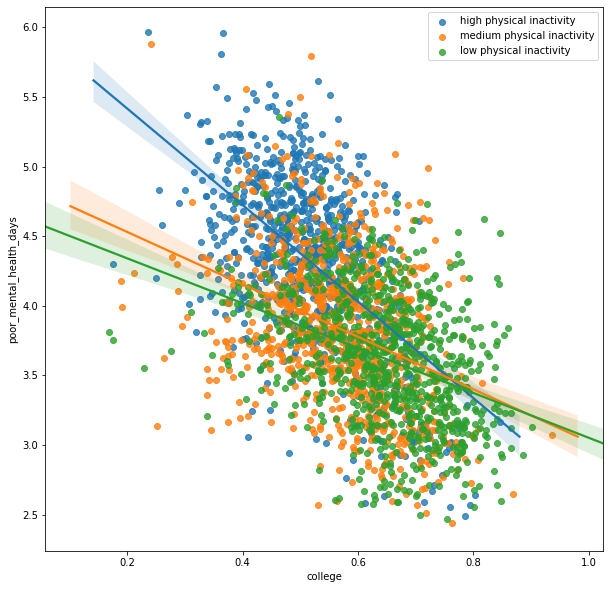

In [200]:
plt.figure(figsize = (10,10))
sns.regplot(x = X_train_high_pi['college'], y = X_train_high_pi['poor_mental_health_days'], label='high physical inactivity')
sns.regplot(x = X_train_medium_pi['college'], y = X_train_medium_pi['poor_mental_health_days'], label='medium physical inactivity')
sns.regplot(x = X_train_low_pi['college'], y = X_train_low_pi['poor_mental_health_days'], label='low physical inactivity')
plt.legend()
plt.show()

In [204]:
# dropping the categorical variables
X_train.drop('physical_inactivity_cat', axis = 1, inplace = True)

In [205]:
X_train_inter = X_train.copy()

In [206]:
for interaction in interactions_to_add:
    X_train_inter[interaction[0] + '_' + interaction[1]] = \
    X_train_inter[interaction[0]] * X_train_inter[interaction[1]]

In [207]:
interaction_score = np.mean(cross_val_score(regression, X_train_inter, y_train, scoring='r2', cv=crossvalidation))
interaction_score

0.8359455998481413

__Summary__: 
<br>

With the interactions in the <code>interactions_to_add</code> variable added to the morel, R<sup>2</sup> increased to 0.855. 

## Polynomials

In [208]:
polynomials = []

for column in X_train.columns:
    
    for degree in [2, 3, 4]:

        data = X_train.copy()
        poly = PolynomialFeatures(degree, include_bias=False)
        X_transformed = poly.fit_transform(X_train[[column]])
        
        data.reset_index(drop=True, inplace=True)
        X_transformed = pd.DataFrame(X_transformed)
        X_transformed.reset_index(drop=True, inplace=True)
        
        data = pd.concat([data.drop(column, axis=1),X_transformed], axis=1)
        
        score = np.mean(cross_val_score(regression, data, y_train, scoring='r2', cv=crossvalidation))
        if score > baseline: polynomials.append((column, degree, round(score, 3)))


In [263]:
polynomials = sorted(polynomials, key = lambda x: x[2],reverse = True)

R_squared for degree = 1 : 0.47331105191024403
R_squared for degree = 2 : 0.48653486000142143
R_squared for degree = 3 : 0.48689918742212246
R_squared for degree = 4 : 0.48977013956466187


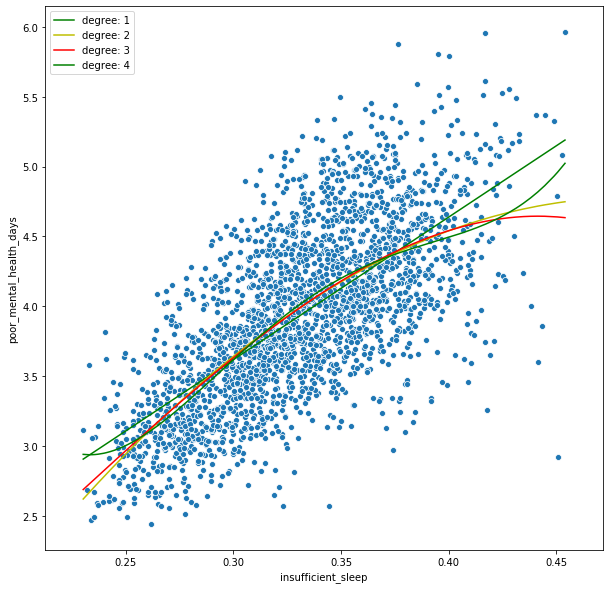

In [258]:
colors = ['g', 'y', 'r','g']

plt.figure(figsize = (10,10))

sns.scatterplot(X_train['insufficient_sleep'], y_train)

for index, degree in enumerate([1,2,3,4]):

    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train[['insufficient_sleep']])
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    y_pred = reg_poly.predict(X_poly_train)
    
    print('R_squared for degree = ' + str(degree) + " : " + str(r2_score(y_train, y_pred)))
    
    sns.lineplot(X_train['insufficient_sleep'], y_pred, color = colors[index], label = 'degree: ' + str(degree))

plt.show()

R_squared for degree = 1 : 0.2612225289122412
R_squared for degree = 2 : 0.2825079159431976
R_squared for degree = 3 : 0.28327000453628837
R_squared for degree = 4 : 0.29043224439540405


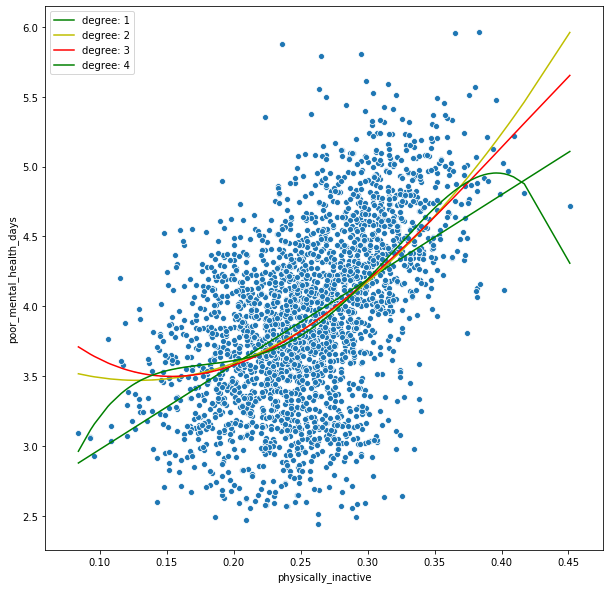

In [259]:
colors = ['g', 'y', 'r','g']

plt.figure(figsize = (10,10))

sns.scatterplot(X_train['physically_inactive'], y_train)

for index, degree in enumerate([1,2,3,4]):

    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train[['physically_inactive']])
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    y_pred = reg_poly.predict(X_poly_train)
    
    print('R_squared for degree = ' + str(degree) + " : " + str(r2_score(y_train, y_pred)))
    
    sns.lineplot(X_train['physically_inactive'], y_pred, color = colors[index], label = 'degree: ' + str(degree))

plt.show()

R_squared for degree = 1 : 0.5474576643213336
R_squared for degree = 2 : 0.5537191909708632
R_squared for degree = 3 : 0.5771375169012791
R_squared for degree = 4 : 0.5941159862408536


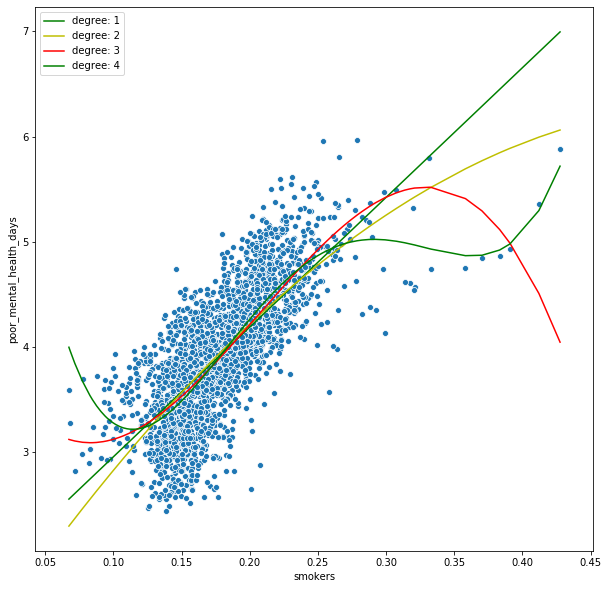

In [260]:
colors = ['g', 'y', 'r','g']

plt.figure(figsize = (10,10))

sns.scatterplot(X_train['smokers'], y_train)

for index, degree in enumerate([1,2,3,4]):

    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train[['smokers']])
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    y_pred = reg_poly.predict(X_poly_train)
    
    print('R_squared for degree = ' + str(degree) + " : " + str(r2_score(y_train, y_pred)))
    
    sns.lineplot(X_train['smokers'], y_pred, color = colors[index], label = 'degree: ' + str(degree))

plt.show()

R_squared for degree = 1 : 0.3695506201053135
R_squared for degree = 2 : 0.39126337080733253
R_squared for degree = 3 : 0.3916319764937478
R_squared for degree = 4 : 0.3931831254172251


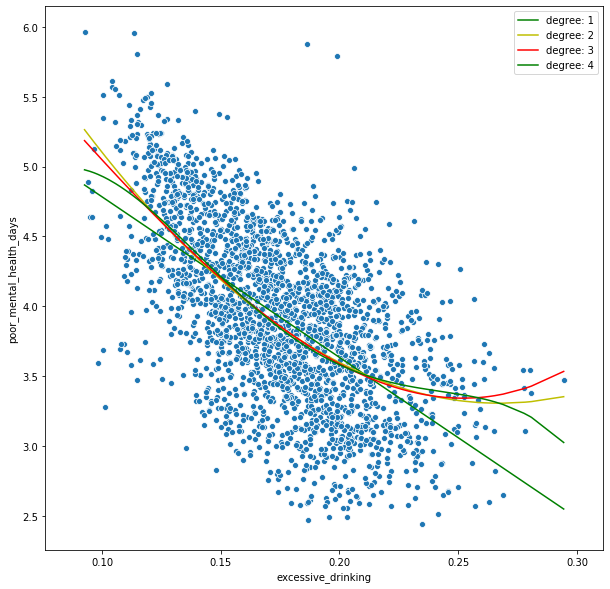

In [261]:
colors = ['g', 'y', 'r','g']

plt.figure(figsize = (10,10))

sns.scatterplot(X_train['excessive_drinking'], y_train)

for index, degree in enumerate([1,2,3,4]):

    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train[['excessive_drinking']])
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    y_pred = reg_poly.predict(X_poly_train)
    
    print('R_squared for degree = ' + str(degree) + " : " + str(r2_score(y_train, y_pred)))
    
    sns.lineplot(X_train['excessive_drinking'], y_pred, color = colors[index], label = 'degree: ' + str(degree))

plt.show()

R_squared for degree = 1 : 0.03819208217482506
R_squared for degree = 2 : 0.043958152707240794
R_squared for degree = 3 : 0.04634706065528105
R_squared for degree = 4 : 0.046781191026338265


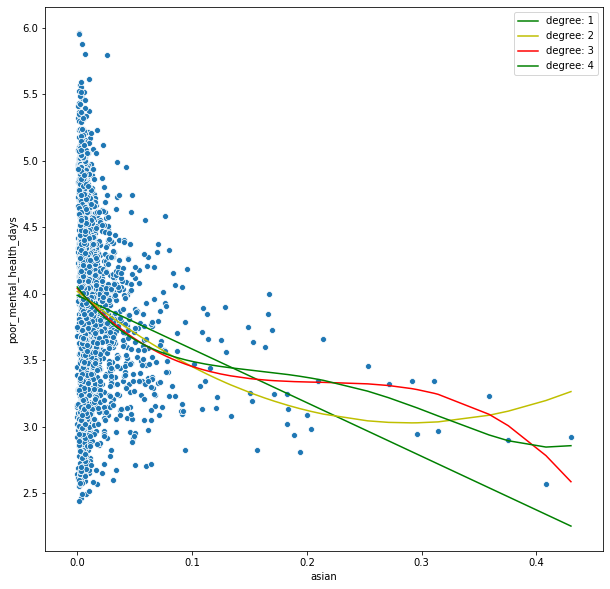

In [262]:
colors = ['g', 'y', 'r','g']

plt.figure(figsize = (10,10))

sns.scatterplot(X_train['asian'], y_train)

for index, degree in enumerate([1,2,3,4]):

    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train[['asian']])
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    y_pred = reg_poly.predict(X_poly_train)
    
    print('R_squared for degree = ' + str(degree) + " : " + str(r2_score(y_train, y_pred)))
    
    sns.lineplot(X_train['asian'], y_pred, color = colors[index], label = 'degree: ' + str(degree))

plt.show()

In [264]:
# adding the top 10 variables

In [328]:
polynomials_to_add = []
for variable in polynomials:
    if len(polynomials_to_add) == 10:
        break
    elif variable[0] not in polynomials_to_add:
        polynomials_to_add.append(variable[0])

In [329]:
polynomials_to_add

['insufficient_sleep',
 'physically_inactive',
 'uninsured_children',
 'smokers',
 'excessive_drinking',
 'children_in_oiverty',
 'social_associations',
 'asian',
 'MHP',
 'college']

In [282]:
# we are adding the four degrees to the dataset

In [283]:
X_train_poly = X_train.copy()

In [284]:
for column in polynomials_to_add:
    for degree in [2,3,4]:
        X_train_poly[column + "_degree" + str(degree)] = X_train_poly[column] ** degree

In [285]:
poly_score = np.mean(cross_val_score(regression, X_train_poly, y_train, scoring='r2', cv=crossvalidation))
poly_score

0.8471908938714863

In [286]:
interaction_score

0.8359455998481413

## Model With All Variables

In [330]:
X_train_inter_poly = X_train.copy()

In [331]:
for column in polynomials_to_add:
    for degree in [2,3,4]:
        X_train_inter_poly[column + "_degree" + str(degree)] = X_train_inter_poly[column] ** degree

In [332]:
for interaction in interactions_to_add:
    X_train_inter_poly[interaction[0] + '_' + interaction[1]] = \
    X_train_inter_poly[interaction[0]] * X_train_inter_poly[interaction[1]]

In [333]:
all_variable_score = np.mean(cross_val_score(regression, X_train_inter_poly, y_train, scoring='r2', cv=crossvalidation))
all_variable_score

0.8574644758040393

In [334]:
scores = [baseline, interaction_score, poly_score, all_variable_score]

In [335]:
scores

[0.8094197441499358,
 0.8359455998481413,
 0.8471908938714863,
 0.8574644758040393]

(0.7, 0.9)

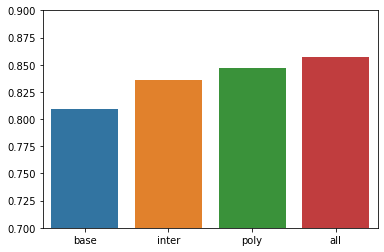

In [336]:
sns.barplot(y = scores, x = ['base', 'inter', 'poly', 'all'])
plt.ylim(0.7,0.9)

In [337]:
cross_validate(regression, X_train_inter_poly, y_train, scoring=('r2', 'neg_mean_squared_error'), cv=crossvalidation,
              return_train_score=True)

{'fit_time': array([0.00945997, 0.00874281, 0.01820207, 0.00473881, 0.00758195]),
 'score_time': array([0.00395322, 0.00300217, 0.00550508, 0.0040791 , 0.0041101 ]),
 'test_r2': array([0.85288531, 0.86695314, 0.86048068, 0.84504156, 0.86196168]),
 'train_r2': array([0.86932495, 0.86711936, 0.86788988, 0.87152713, 0.86762716]),
 'test_neg_mean_squared_error': array([-0.05926769, -0.05171323, -0.05147137, -0.05389968, -0.05244643]),
 'train_neg_mean_squared_error': array([-0.04853806, -0.04984655, -0.0502125 , -0.0495051 , -0.04993546])}

We are not really overfitting...